In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy

import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch

from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import check_if_close_to_obs
from stg_energy.common import col, svg, get_labels_8pt
import stg_energy.fig2_inference.viz as viz
from sbi.analysis import pairplot

# Figure 1

In [2]:
pd.options.display.max_columns=999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = '../svg/panel_a_appendix_singularity.svg'
PANEL_B = '../svg/panel_b_appendix_singularity.svg'
PANEL_C = '../svg/panel_c_appendix_singularity.svg'
# PANEL_C = '../svg/panel_c.svg'
# PANEL_D = '../svg/panel_d.svg'
# PANEL_E = '../svg/panel_e.svg'
# PANEL_F = '../svg/panel_f.svg'
# PANEL_G = '../svg/panel_g.svg'
# PANEL_H = '../svg/panel_h.svg'
# PANEL_I = '../svg/panel_i.svg'

# Panel B: experimental data

In [5]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [6]:
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

### Select the simulations that were close

In [7]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster"
theta = pd.read_pickle(path + '/close_to_xo_circuit_parameters.pkl')
x = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
seeds = np.load(path + '/close_to_xo_seeds.npy')
theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [8]:
theta.to_numpy().shape

(35939, 31)

### Load network

In [9]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.base_constraint.lower_bound
upper_bound = prior.support.base_constraint.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T
# dimensions = 31
# lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T

### Scale membrane conductances

In [10]:
path = "/home/michael/Documents/STG_energy/results/simulation_data_Tube_MLslurm_cluster/01_simulate_11deg"
x_prior = pd.read_pickle(path + "/data/valid_simulation_outputs.pkl")
num_std = np.std(x_prior.to_numpy(), axis=0)

In [11]:
energies = x["energies"]
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)
custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }

In [12]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [118]:
def compute_xs(highest_or_lowest="lowest", all_singularities = [1.0, 2.0, 3.0, 4.0, 5.0]):
    all_stats = []

    for singularity_limit_factor in all_singularities:

        summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000
        inds = np.argsort(summed_energies)
        if highest_or_lowest == "hightest":
            inds = inds[::-1]
        sorted_energies = summed_energies[inds]

        sorted_energies = summed_energies[inds]
        num_vals = sorted_energies.shape[0]

        quantile = 0.001
        one_percent_quantile = int(num_vals * quantile)
        one_percent_energy = sorted_energies[one_percent_quantile]

        if highest_or_lowest == "hightest":
            min_energy_condition = summed_energies > one_percent_energy
        else:
            min_energy_condition = summed_energies < one_percent_energy
        min_energy_theta = theta_np[min_energy_condition]
        min_energy_x = x_np[min_energy_condition]
        min_energy_energy = summed_energies[min_energy_condition]
        low_seeds = seeds[min_energy_condition]

        min_energy_theta[:, :24] *= singularity_limit_factor
        min_energy_theta[:, 24:] += np.log(singularity_limit_factor)
        
        low_theta = pd.DataFrame(min_energy_theta, columns=theta.columns)

        all_traces = []
        num_sims = 20
        for parameter_index in range(num_sims):
            all_traces.append(simulate(low_theta.loc[parameter_index], seed=int(low_seeds[parameter_index])))

        stats = pd.concat([summary_stats(t, stats_customization=custom_stats, t_burn_in=1000) for t in all_traces])
        all_stats.append(stats)
#         xs = pd.DataFrame(min_energy_x, columns=stats.columns)

    return all_stats
    

def compute_dists(all_stats):
    all_dists = []
    all_valid_fractions = []
    for stats in all_stats:
    
        # Replace NaN with xo - 3*prior_std
        num_features = 15
        replacement = xo[:num_features] - 1 * num_std[:num_features]
        stats_sim = stats.to_numpy()[:, :num_features]
        all_good = np.invert(np.any(np.isnan(stats_sim), axis=1))
        stats_sim = stats_sim[all_good]
        fraction_of_good = np.sum(all_good) / len(stats)

        diff = xo[:num_features] - stats_sim
        weighted_diff = diff / num_std[:num_features]
        dist = np.sqrt(np.sum(weighted_diff**2, axis=1))
        av_dist = np.mean(dist)
        all_dists.append(av_dist)
        all_valid_fractions.append(fraction_of_good)
    return all_dists, all_valid_fractions

def compute_cycle(all_stats):
    all_dists = []
    all_valid_fractions = []
    for stats in all_stats:
    
        stats_sim = stats.to_numpy()
        all_good = np.invert(np.any(np.isnan(stats_sim), axis=1))
        stats_sim = stats_sim[all_good]

#         print("stats_sim", stats_sim)
        diff = xo[0] - stats_sim[:, 0]
        weighted_diff = diff / num_std[0]
        av_dist = np.mean(np.abs(weighted_diff))
        all_dists.append(av_dist)
    return all_dists

def compute_duty_abpd(all_stats):
    all_dists = []
    all_valid_fractions = []
    for stats in all_stats:
        stats_sim = stats["duty_cycles"]["PM"].to_numpy()
        all_good = np.invert(np.any(np.isnan(stats_sim)))
        stats_sim = stats_sim[all_good]
        diff = xo[4] - np.squeeze(stats_sim)
        weighted_diff = diff / num_std[4]
        av_dist = np.mean(np.abs(weighted_diff))
        all_dists.append(av_dist)
    return all_dists

In [119]:
#cheapest, cheapest_valid = compute_dists("lowest")

In [120]:
# all_singularities = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
# all_singularities = [1.0, 2.0, 3.0, 4.0, 5.0]
# all_singularities = 1.0 / np.asarray([1.0, 1.5, 2.0, 2.5, 3.0])

# computed_stats = compute_xs("hightest", all_singularities=all_singularities)

In [121]:
most_expensive, most_expensive_valid = compute_dists(computed_stats)
cycle_dur = compute_cycle(computed_stats)
duty_cycle_abpd = compute_duty_abpd(computed_stats)

In [122]:
# np.savez("singularity_simulations.npz", most_expensive=most_expensive, cycle_dur=cycle_dur, duty_cycle_abpd=duty_cycle_abpd)

In [123]:
# data = np.load("singularity_simulations.npz")
# most_expensive = data["most_expensive"]
# cycle_dur = data["cycle_dur"]
# duty_cycle_abpd = data["duty_cycle_abpd"]

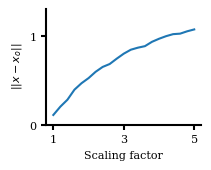

In [124]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    ax.plot(all_singularities, most_expensive)
    ax.set_xlabel("Scaling factor")
    ax.set_ylabel(r"$\;||x - x_o||\;$")
    ax.set_ylim([0.0, 1.3])
    ax.set_xticks([1, 3, 5])
    ax.set_yticks([0, 1])
    plt.subplots_adjust(wspace=0.7)
    plt.savefig(PANEL_A, facecolor='None', dpi=300, bbox_inches='tight')

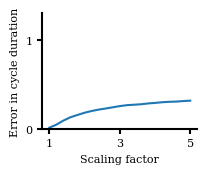

In [125]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    ax.plot(all_singularities, cycle_dur)
    ax.set_xlabel("Scaling factor")
    ax.set_ylabel("Error in cycle duration")
    ax.set_ylim([0.0, 1.3])
    ax.set_xticks([1, 3, 5])
    ax.set_yticks([0, 1])
    plt.subplots_adjust(wspace=0.7)
    plt.savefig(PANEL_B, facecolor='None', dpi=300, bbox_inches='tight')

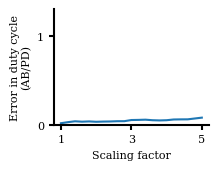

In [126]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
    ax.plot(all_singularities, duty_cycle_abpd)
    ax.set_xlabel("Scaling factor")
    ax.set_ylabel("Error in duty cycle\n(AB/PD)")
    ax.set_ylim([0.0, 1.3])
    ax.set_xticks([1, 3, 5])
    ax.set_yticks([0, 1])
    plt.subplots_adjust(wspace=0.7)
    plt.savefig(PANEL_C, facecolor='None', dpi=300, bbox_inches='tight')

#### Assemble figure

In [127]:
color_mixture1 = 0.33 * np.asarray(list(col['CONSISTENT1'])) + 0.67 * np.asarray(
    list(col['CONSISTENT2']))
color_mixture2 = 0.67 * np.asarray(list(col['CONSISTENT1'])) + 0.33 * np.asarray(
    list(col['CONSISTENT2']))

In [128]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [129]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "4.1cm",
    Panel(
          SVG(PANEL_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
        Text("a", -1.5*factor_svg, 2.4*factor_svg, **kwargs_text),
    ).move(1.5*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_B).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
        Text("b", -1.5*factor_svg, 3.0*factor_svg, **kwargs_text),
    ).move(41.25*factor_svg, -0.6*factor_svg),
           
    Panel(
          SVG(PANEL_C).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
        Text("c", -1.5*factor_svg, 2.4*factor_svg, **kwargs_text),
    ).move(80.5*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig2_supp_singular_limit.svg")
svg('../fig/fig2_supp_singular_limit.svg')